In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import cluster
import optimization
from series_to_supervised import series_to_supervised
import math
%matplotlib nbagg

### Define directories and load Data

In [2]:
# directories to load data
directory_minute_sorted = '/home/doltsinis/net_folders/Monsoon/ALDK Electrolysis Optimization Scenario/split and sorted data/minuteALDKSort'
directory_shift = '/home/doltsinis/net_folders/Monsoon/ALDK Electrolysis Optimization Scenario/split and sorted data/shiftALDK'
directory_day = '/home/doltsinis/net_folders/Monsoon/ALDK Electrolysis Optimization Scenario/split and sorted data/dayALDK'
directory_general = '/home/doltsinis/net_folders/Monsoon/ALDK Electrolysis Optimization Scenario'

In [3]:
# short list of variables chosen from RTA (process experts)
# ---- minute data ----
variables_for_height = pd.read_excel(directory_general + '/Short list of variables for prediction from Ameline.xls', sheet_name=4,  usecols='A')
variables_for_thermal = pd.read_excel(directory_general + '/Short list of variables for prediction from Ameline.xls', sheet_name=4, usecols='D')

In [10]:
# read data files and assign them to variables in varListA and varListB
input_Dir = directory_shift
#def read_and_assign_data(input_Dir = directory_shift):
var_List_A = []
var_List_B = []
for filename_A,filename_B  in zip(os.listdir(input_Dir + '/A'), os.listdir(input_Dir + '/B')):
    temp_Name_A = pd.read_csv(input_Dir + '/A/' + filename_A)#, usecols=toPredictVar)
    #temp_Name_A.DAT = pd.to_datetime(temp_Name_A.DAT, format='%d/%m/%Y %H:%M:%S') # define proper date format
    temp_Name_A.sort_values('DAT', inplace=True) # sort data in case they are not sorted 
    temp_Name_A.columns = temp_Name_A.columns.str.upper()
    temp_Name_A.fillna(method='bfill', inplace=True)
    temp_Name_A.set_index('DAT', inplace=True)
    vars()[filename_A[0:4]] = temp_Name_A # create variable name from string --> filename
    var_List_A.append(filename_A[0:4]) # variable name -> 

    temp_Name_B = pd.read_csv(input_Dir + '/B/' + filename_B)#, usecols=toPredictVar)
    #temp_Name_B.DAT = pd.to_datetime(tempName_B.DAT, format='%d/%m/%Y %H:%M:%S')
    temp_Name_B.sort_values('DAT', inplace=True)
    temp_Name_B.columns = temp_Name_B.columns.str.upper()
    temp_Name_B.fillna(method='bfill', inplace=True) # fill empty values 
    temp_Name_B.set_index('DAT', inplace=True)
    vars()[filename_B[0:4]] = temp_Name_B # cretae variable name from string --> filename
    var_List_B.append(filename_B[0:4])

### Load and compare minute vs Shift data (indicative sample)

In [25]:
# load just one minute data set as a sample
minute_A001 = pd.read_csv(directory_minute_sorted + '/A/A001.csv')
minute_A001.columns = minute_A001.columns.str.upper()
#minute_A001.DAT = pd.to_datetime(minute_A001.DAT, format='%d/%m/%Y %H:%M:%S')
minute_A001.DAT = pd.to_datetime(minute_A001.DAT)
minute_A001.sort_values('DAT', inplace=True)
minute_A001.set_index('DAT', inplace=True)
minute_A001.head()

,COD_CUV,IMFC,UMFC,RMFC,RKFC,RCMFC,RDEMFC,RCFC,RCACFC,RTHFC,...,RMI,RMIMIN,DRMI,WPENTE,PENTHFMAX,RTA_HC,INTERRUPT_CYCLE,NBDOSAR,WRMM,KRTA
DAT,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:16,A001,397.1,3.971,NaN,5.84,0.0,0.0,0.0,0.0,0.0,...,5.841,5.84,1.0,2.0,0.0,0.0,0.0,0.0,2.0,99.3
2017-01-01 00:01:16,A001,397.4,3.974,5.845,5.84,0.0,0.0,0.0,0.0,0.0,...,5.841,5.84,1.0,3.0,-1.0,0.0,0.0,0.0,2.0,99.3
2017-01-01 00:02:16,A001,394.2,3.961,NaN,5.84,0.0,0.0,0.0,0.0,0.0,...,5.847,5.84,7.0,4.0,-1.0,0.0,0.0,0.0,2.0,99.3
2017-01-01 00:03:16,A001,390.9,3.945,NaN,5.84,0.0,0.0,0.0,0.0,0.0,...,5.855,5.84,15.0,4.0,-1.0,0.0,0.0,0.0,2.0,99.3
2017-01-01 00:04:16,A001,389.6,3.939,NaN,5.84,0.0,0.0,0.0,0.0,0.0,...,5.865,5.84,25.0,4.0,-1.0,0.0,0.0,0.0,2.0,99.3


In [26]:
# find common signals between minute and shift data
common_signals = vars()[var_List_A[0]].columns[vars()[var_List_A[0]].columns.isin(minute_A001.columns.values)]
common_signals

Index(['COD_CUV', 'HMA', 'HBACT', 'HBNET', 'WRMM', 'WPENTE', 'DRMI'], dtype='object')

In [27]:
shift_A001 = pd.read_csv(directory_shift + '/A/A001.csv')
shift_A001.DAT = pd.to_datetime(shift_A001.DAT)
shift_A001.set_index('DAT', inplace=True) # define date as the index
shift_A001.head()

,COD_CUV,POTSTATE,AGEBSQ,POTAGE,ALF3,ALF3C,ALF3D,AMALF3,AMBB,AMCAF2,...,NDRTAHC,WRMM,WPENTE,DRMI,DRMIMOY,NBP2I30,NBINTPH2,RCM,RCDL,RECALC
DAT,,,,,,,,,,,,,,,,,,,,,
2017-01-01 14:00:00,A001,3.0,1051.8750,1051.8750,NaN,11.3,9.8,NaN,NaN,NaN,...,0,1.1027,2.7785,54.3750,13,0,0,0.0,0.0,0
2017-01-01 22:00:00,A001,3.0,1052.2083,1052.2083,NaN,11.3,9.8,NaN,NaN,NaN,...,0,3.1387,12.4724,68.8333,18,2,2,0.0,0.0,0
2017-01-02 06:00:00,A001,3.0,1052.5417,1052.5417,13.5,11.3,13.5,NaN,NaN,NaN,...,0,3.9072,8.4932,77.8333,39,2,0,0.0,0.0,0
2017-01-02 14:00:00,A001,3.0,1052.8750,1052.8750,NaN,11.3,13.5,NaN,NaN,NaN,...,0,5.7966,11.2979,53.5556,9,1,2,0.0,0.0,0
2017-01-02 22:00:00,A001,3.0,1053.2083,1053.2083,NaN,11.3,13.5,NaN,NaN,NaN,...,0,3.9242,8.7156,62.0000,13,2,1,0.0,0.0,0


In [28]:
# compare minute and shift based prediction on the same time scale
shift_A001.fillna(method='pad', inplace=True)
minute_A001.fillna(method='pad', inplace=True)

<IPython.core.display.Javascript object>


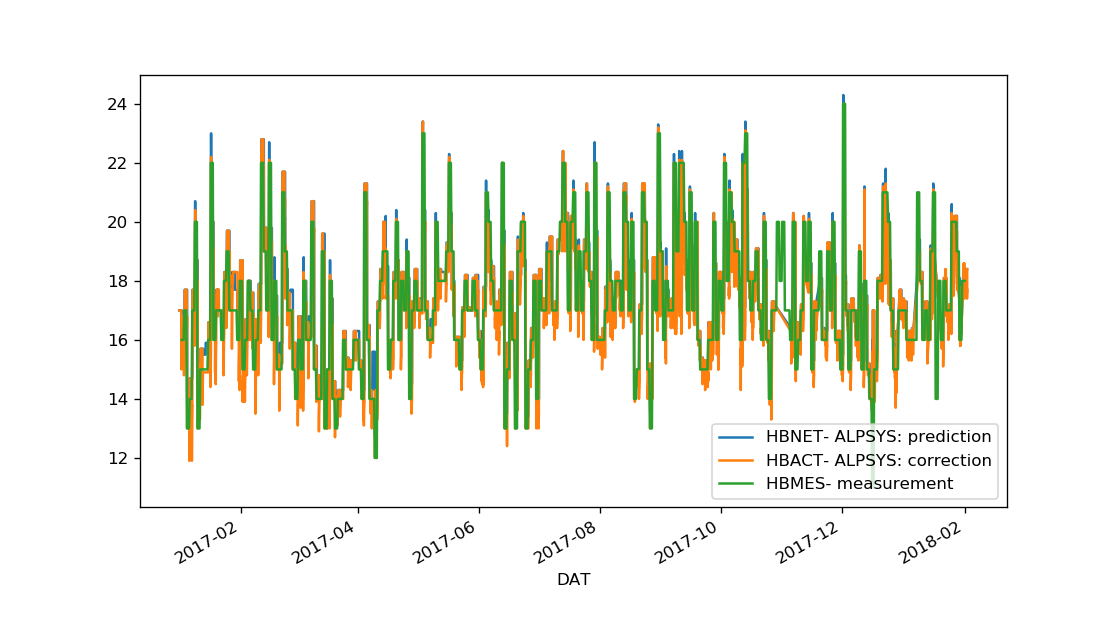

In [31]:
minute_A001.HBNET.plot()
minute_A001.HBACT.plot()
shift_A001.HBMES.plot()
plt.legend(('HBNET'+ '- ALPSYS: prediction','HBACT'+ '- ALPSYS: correction' , 'HBMES' + '- measurement'))

### Shift based data analysis for series clustering 

<IPython.core.display.Javascript object>


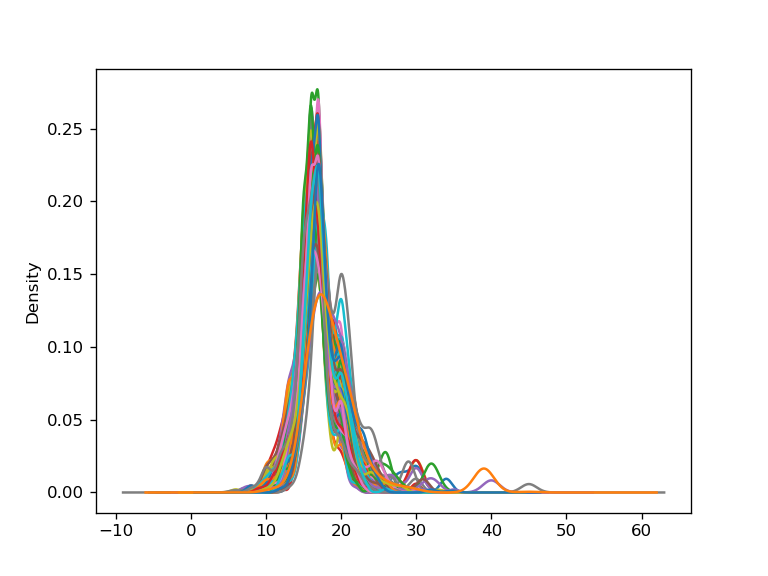

<IPython.core.display.Javascript object>


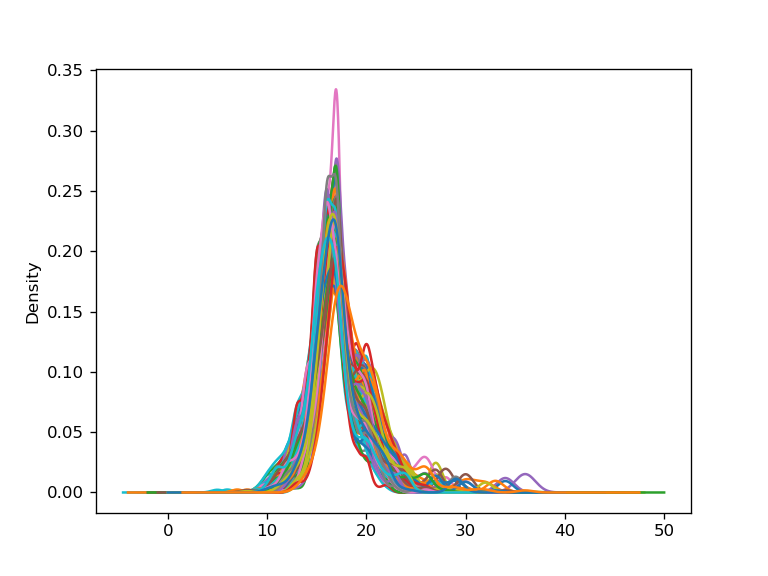

<IPython.core.display.Javascript object>


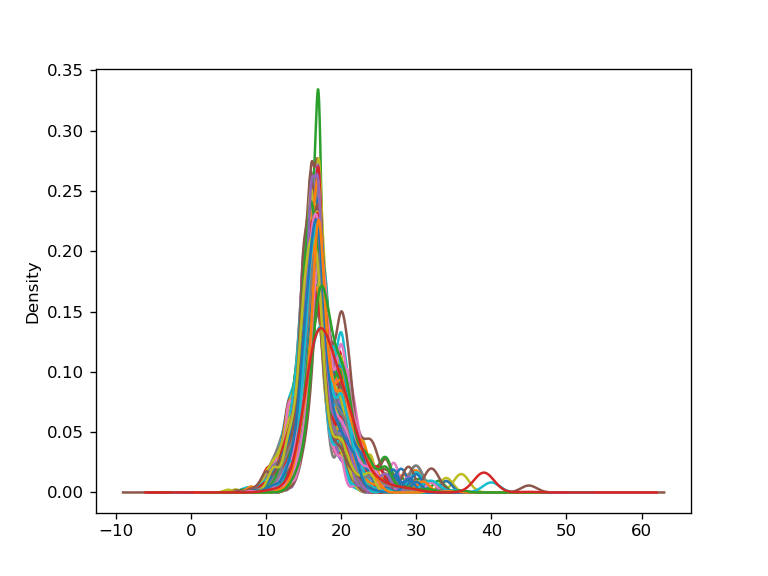

In [42]:
# plot HBMES densities
for seriesA, seriesB in zip(var_List_A, var_List_B):
    plt.figure(1)
    vars()[seriesA].HBMES.plot(kind='density')
    plt.figure(2)
    vars()[seriesB].HBMES.plot(kind='density')
    plt.figure(3)
    vars()[seriesB].HBMES.plot(kind='density')
    vars()[seriesA].HBMES.plot(kind='density')

#plot1.title('density plots of height measuremet in area A')
#plot2.title('density plots of height measuremet in area B')

In [ ]:
# load Dynamic Time Warping matrices
pd.read_csv()